In [138]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from matplotlib import style
style.use('seaborn-white')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [139]:
# Loading simulated results for comparsion with SINDy
df_IDM = pd.read_csv('myResults/NAPOLI2/Exp/Model_1/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_IDM = df_IDM.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_IDM = pd.DataFrame(df_IDM)

df_GIPPS = pd.read_csv('myResults/NAPOLI2/Exp/Model_2/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_GIPPS = df_GIPPS.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_GIPPS = pd.DataFrame(df_GIPPS)

df_FVDM_CTH = pd.read_csv('myResults/NAPOLI2/Exp/Model_3/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_FVDM_CTH = df_FVDM_CTH.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_FVDM_CTH = pd.DataFrame(df_FVDM_CTH)

df_FVDM_SIG = pd.read_csv('myResults/NAPOLI2/Exp/Model_4/VehicleID_1/simData/Simulation_CalExp_1_ValExp_1_RMSE(S).csv', header=None,low_memory=False, encoding='UTF-8')
df_FVDM_SIG = df_FVDM_SIG.rename(columns={0:"FOLLOW_VEL",1:"FOLLOW_PRED_V",2:"SPACING_REAL",3:"SPACING_PRED",4:"FOLLOW_ACC",5:"FOLLOW_PRED_A"})
df_FVDM_SIG = pd.DataFrame(df_FVDM_SIG)

In [140]:
df = pd.read_csv('Data/ASTAZERO/dataVehicle1.csv', header=None,low_memory=False, encoding='UTF-8')
df = df.rename(columns={0:"TIME",1:"LEAD_POS",2:"FOLLOW_POS",3:"LEAD_VEL",4:"FOLLOW_VEL",5:"LEAD_LENGTH"})
df = pd.DataFrame(df)
print(df)

         TIME      LEAD_POS    FOLLOW_POS  LEAD_VEL  FOLLOW_VEL  LEAD_LENGTH
0         1.0   4466.914835   4458.758374  0.021174    0.007862        5.196
1         1.1   4466.916899   4458.759248  0.020108    0.009621        5.196
2         1.2   4466.918861   4458.760291  0.019126    0.011245        5.196
3         1.3   4466.920728   4458.761491  0.018225    0.012739        5.196
4         1.4   4466.922510   4458.762833  0.017404    0.014105        5.196
...       ...           ...           ...       ...         ...          ...
11752  1176.2  27440.670420  27431.138280  0.042988    0.011987        5.196
11753  1176.3  27440.674690  27431.139230  0.042337    0.006957        5.196
11754  1176.4  27440.678880  27431.139640  0.041571    0.001273        5.196
11755  1176.5  27440.682990  27431.139710  0.040687    0.000000        5.196
11756  1176.6  27440.687010  27431.139710  0.039682    0.000000        5.196

[11757 rows x 6 columns]


In [141]:
############ Converting Python DataFrames to Numpy Arrays ############

t = np.asarray(df["TIME"])
leadPos = np.asarray(df['LEAD_POS']) # Leading vehicle position 
followPos = np.asarray(df['FOLLOW_POS']) # Follow vehicle position 
vlead = np.asarray(df['LEAD_VEL']) # Leading vehicle velocity
v = np.asarray(df['FOLLOW_VEL']) # Follow vehicle velocity
leadLen = np.asarray(df["LEAD_LENGTH"]) # lead vehicle length 
leadVehLen = df.iat[0,5]
s = leadPos - followPos - leadLen[0]
#dt = t[1] - t[0]
dt = 0.1

sCheck = s<=0   # making sure that it is positive 
vehLen = leadLen!=5.196000000000001  # check if all the vehicles have the same length 
print(np.count_nonzero(vehLen)) # count the number of True 
print(np.count_nonzero(sCheck)) # count number of True 

statTrajec = 0
endTrajec = -1

#t = np.linspace(0, 188.9, 1889, endpoint=False) # 288.4 for JIANG # 188.9 for NAPOLI
t = t[statTrajec:endTrajec]

# Without Scaling 
v = v[statTrajec:endTrajec]
s = s[statTrajec:endTrajec]
vlead = vlead[statTrajec:endTrajec]

followPos = followPos[statTrajec:endTrajec]
leadPos = leadPos[statTrajec:endTrajec]

############ Calculating the Follower Derivative ############

FD = ps.SmoothedFiniteDifference()
v_p = FD(v, t) #HDWY Derivative #(670,1)
v_p = np.reshape(v_p, (v.size,)) #(670,)
  
min_acc = np.min(v_p)  # min acceleration 
max_acc = np.max(v_p)  # max acceleration 

0
0


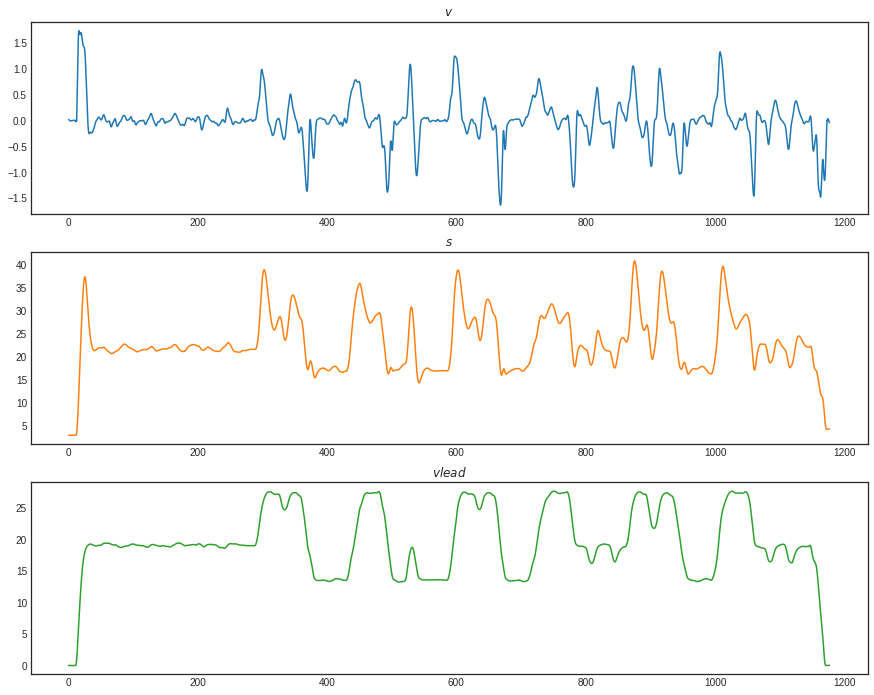

In [142]:
# Plotting the data
# plt.rc('font', size=10)
fig, (ax1,ax2,ax3) = plt.subplots(3)

statTraj = 0 #7000
endsTraj = -1 #8900

fig.set_figheight(12)
fig.set_figwidth(15)
#ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.plot(t[statTraj:endsTraj], v_p[statTraj:endsTraj])
ax1.set_title('$v$')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.set_title('$vlead$')

plt.show()

# LSTM

In [143]:
st_Traj = 0
en_Traj = 9405 #1511 #9405 # 2307

X_train = np.stack((v[st_Traj:en_Traj],s[st_Traj:en_Traj],vlead[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

Y_train = np.stack((v_p[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)
#Y_train = np.stack((v[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)
#Y_train = np.stack((s[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

X_prior = np.stack((v,s,vlead,t), axis=1)  # For plotting in this section 

X_Full = np.stack((v,s,vlead,v_p), axis=1)
#X_Full = np.stack((v,s,vlead,v), axis=1)
#X_Full = np.stack((v,s,vlead,s), axis=1)

np.savetxt("lstm_data.csv", X_Full, delimiter=",")

In [144]:
df_lstm = pd.read_csv("lstm_data.csv", header=None,low_memory=False, encoding='UTF-8')
df_lstm = df_lstm.rename(columns={0:"FOLLOW_VEL",1:"HEADWAY",2:"LEAD_VEL",3:"FOLLOW_ACC"})
df_lstm = pd.DataFrame(df_lstm)
df_lstm

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,0.007862,2.960461,0.021174,0.018270
1,0.009621,2.961651,0.020108,0.016915
2,0.011245,2.962570,0.019126,0.015590
3,0.012739,2.963237,0.018225,0.014301
4,0.014105,2.963677,0.017404,0.013049
...,...,...,...,...
11751,0.016394,4.333230,0.043526,-0.041087
11752,0.011987,4.336140,0.042988,-0.042733
11753,0.006957,4.339460,0.042337,-0.042888
11754,0.001273,4.343240,0.041571,-0.041551


In [145]:
target = 'FOLLOW_ACC'
features = list(df_lstm.columns.difference([target]))

past_seq = 1
df_lstm[target] = df_lstm[target].shift(-past_seq)
df_lstm = df_lstm.iloc[:-past_seq]
df_lstm

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,0.007862,2.960461,0.021174,0.016915
1,0.009621,2.961651,0.020108,0.015590
2,0.011245,2.962570,0.019126,0.014301
3,0.012739,2.963237,0.018225,0.013049
4,0.014105,2.963677,0.017404,0.011833
...,...,...,...,...
11750,0.020205,4.330690,0.043955,-0.041087
11751,0.016394,4.333230,0.043526,-0.042733
11752,0.011987,4.336140,0.042988,-0.042888
11753,0.006957,4.339460,0.042337,-0.041551


In [146]:
test_start = en_Traj
df_lstm_train = df_lstm.loc[:test_start].copy()
df_lstm_test = df_lstm.loc[test_start:].copy()

In [147]:
target_mean = df_lstm_train[target].mean()
target_stdev = df_lstm_train[target].std()

vel_mean = df_lstm_train['FOLLOW_VEL'].mean()
vel_stdev = df_lstm_train['FOLLOW_VEL'].std()

headway_mean = df_lstm_train['HEADWAY'].mean()
headway_stdev = df_lstm_train['HEADWAY'].std()

for c in df_lstm_train.columns:
    mean = df_lstm_train[c].mean()
    stdev = df_lstm_train[c].std()

    df_lstm_train[c] = (df_lstm_train[c] - mean) / stdev
    df_lstm_test[c] = (df_lstm_test[c] - mean) / stdev

In [148]:
df_lstm_train.head(11)

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,-3.565800,-3.336137,-3.710998,-0.021113
1,-3.565485,-3.335942,-3.711197,-0.024351
2,-3.565194,-3.335791,-3.711380,-0.027501
3,-3.564926,-3.335681,-3.711548,-0.030563
4,-3.564681,-3.335609,-3.711701,-0.033535
5,-3.564458,-3.335572,-3.711840,-0.036418
6,-3.564257,-3.335565,-3.711965,-0.039212
7,-3.564076,-3.335586,-3.712077,-0.041918
8,-3.563916,-3.335632,-3.712176,-0.044535
9,-3.563775,-3.335700,-3.712264,-0.047062


In [149]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [150]:
#i = 0
#sequence_length = 10

#train_dataset = SequenceDataset(
#    df_lstm_train,
#    target=target,
#    features=features,
#    sequence_length=sequence_length
#)

#X, y = train_dataset[i]
#print(X)
#print(y)

In [151]:
#train_loader = DataLoader(train_dataset, batch_size=3, shuffle=False)

#X, y = next(iter(train_loader))
#print(X.shape)
#print(X)

In [152]:
val_Traj = 8465 #8465 #1359
df_lstm_train_c = df_lstm_train.loc[:val_Traj].copy()
df_lstm_val_c = df_lstm_train.loc[val_Traj:].copy()
# df_lstm_test should remain same 

In [153]:
batch_size = 4  # 4
sequence_length = 5  # 5

train_dataset = SequenceDataset(
    df_lstm_train_c,
    target=target,
    features=features,
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_lstm_val_c,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_lstm_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # True before
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 5, 3])
Target shape: torch.Size([4])


In [154]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_feat, hidden_units):
        super().__init__()
        self.num_feat = num_feat  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 3 # IT WAS 1 BEFORE

        self.lstm = nn.LSTM(
            input_size=num_feat,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [155]:
learning_rate = 5e-5
num_hidden_units = 200 #24 before

model = ShallowRegressionLSTM(num_feat=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [156]:
for parameter in model.parameters():
    print(parameter.shape)
sum(p.numel() for p in model.parameters() if p.requires_grad)    

torch.Size([800, 3])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([800, 200])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([800, 200])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([1, 200])
torch.Size([1])


807401

In [157]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def val_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Val. loss: {avg_loss}")

In [158]:
print("Untrained test\n--------")
val_model(val_loader, model, loss_function)
print()

for ix_epoch in range(600):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_model(val_loader, model, loss_function)
    print()

Untrained test
--------
Val. loss: 1.2203925709557382

Epoch 0
---------
Train loss: 0.70531752242624
Val. loss: 0.5778407874914079

Epoch 1
---------
Train loss: 0.2950613240222827
Val. loss: 0.34436830823498665

Epoch 2
---------
Train loss: 0.2393311064507946
Val. loss: 0.27383370124764767

Epoch 3
---------
Train loss: 0.2162269034255032
Val. loss: 0.25058293617576727

Epoch 4
---------
Train loss: 0.2014803462314433
Val. loss: 0.23792266400138656

Epoch 5
---------
Train loss: 0.1890793705438978
Val. loss: 0.22784438988243896

Epoch 6
---------
Train loss: 0.17750096959112366
Val. loss: 0.21918030161829868

Epoch 7
---------
Train loss: 0.16641525870270338
Val. loss: 0.21245924924245113

Epoch 8
---------
Train loss: 0.15590608737456157
Val. loss: 0.20843918307197376

Epoch 9
---------
Train loss: 0.1462007343522552
Val. loss: 0.20751419676136157

Epoch 10
---------
Train loss: 0.13745517243488528
Val. loss: 0.20977325476238282

Epoch 11
---------
Train loss: 0.12982012350217687
V

In [159]:
def predict_old(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [160]:
train_eval_dataset = SequenceDataset(
    df_lstm_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_eval_loader = DataLoader(train_eval_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_lstm_train[ystar_col] = predict_old(train_eval_loader, model).numpy()
df_lstm_test[ystar_col] = predict_old(test_loader, model).numpy()

df_out = pd.concat((df_lstm_train, df_lstm_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       FOLLOW_ACC  Model forecast
0        0.016915        0.058932
1        0.015590        0.058929
2        0.014301        0.058920
3        0.013049        0.058893
4        0.011833        0.058796
...           ...             ...
11750   -0.041087        0.142038
11751   -0.042733        0.142266
11752   -0.042888        0.142544
11753   -0.041551        0.142874
11754   -0.038970        0.143260

[11756 rows x 2 columns]


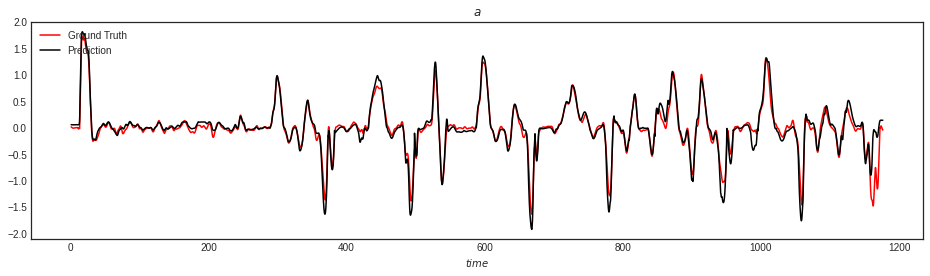

In [161]:
# Plotting 
true_acc = df_out['FOLLOW_ACC'].to_numpy()
pred_acc = df_out['Model forecast'].to_numpy()

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

g1, = ax.plot(t[:], true_acc, 'r')   # use v_p as well 
p1, = ax.plot(t[:], pred_acc, 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Ground Truth', 'Prediction'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

In [162]:
# save the model 
#with open('ResearchUpdate#43/LSTModels/JIANG/LSTM_Stand_JIANG(A).pkl','wb') as f:
#    pickle.dump(model,f)

In [163]:
# loading the model
#with open('ResearchUpdate#43/LSTModels/NAPOLI/LSTM_Stand_NAPOLI(S).pkl', 'rb') as f:
#    model = pickle.load(f)

# RMSE(A)

In [164]:
train_size = np.array(df_lstm_train).shape[0]
test_size = np.array(df_lstm_test).shape[0]

lstm_train_a = torch.zeros(train_size)   # contains unnormalized predictions 
lstm_train_v = torch.zeros(train_size)
lstm_train_pos = torch.zeros(train_size)
lstm_train_s = torch.zeros(train_size)

lstm_test_a = torch.zeros(test_size)
lstm_test_v = torch.zeros(test_size)
lstm_test_pos = torch.zeros(test_size)
lstm_test_s = torch.zeros(test_size)

lstm_train_v[0] = v[0]
lstm_train_pos[0] = followPos[0]
lstm_train_s[0] = s[0]

#lstm_test_v[0] = v[train_size]
#lstm_test_pos[0] = followPos[train_size]
#lstm_test_s[0] = s[train_size]

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    k = 0
    if data_loader == test_loader:
        lstm_test_v[0] = lstm_train_v[train_size-1]
        lstm_test_pos[0] = lstm_train_pos[train_size-1]
        lstm_test_s[0] = lstm_train_s[train_size-1]
    with torch.no_grad():
        for X, _ in data_loader:
            if data_loader == train_eval_loader:
                y_star = model(X)                                                  # Normalize ACC 
                lstm_train_a[k] = y_star*target_stdev + target_mean                # Unnormalize ACC
                if k != train_size-1:
                    lstm_train_v[k+1] = lstm_train_v[k]+(lstm_train_a[k])*(0.1)        # Unnormalize VEL 
                    norm_v = (lstm_train_v[k+1]-vel_mean) / vel_stdev                  # Normalize VEL
                    df_lstm_train.loc[k+1, 'FOLLOW_VEL'] = norm_v.item()               # Updating Dataframe   
                    lstm_train_pos[k+1] = lstm_train_pos[k] + (lstm_train_v[k+1]+lstm_train_v[k])*(dt) / 2 #+ (0.5)*(lstm_train_a[k])*(dt**2) # Unnormalize POS
                    lstm_train_s[k+1] = leadPos[k+1] - lstm_train_pos[k+1] - leadLen[0]           # Calculating HEADWAY
                    h_star_norm = (lstm_train_s[k+1]-headway_mean) / headway_stdev                  # Normalize HEADWAY
                    df_lstm_train.loc[k+1, 'HEADWAY'] = h_star_norm.item()             # Updating Dataframe 
            elif data_loader == test_loader:
                y_star = model(X)                                                  # Normalize ACC 
                lstm_test_a[k] = y_star*target_stdev + target_mean                 # Unnormalize ACC
                if k != test_size-1:
                    lstm_test_v[k+1] = lstm_test_v[k]+(lstm_test_a[k])*(0.1)           # Unnormalize VEL 
                    norm_v = (lstm_test_v[k+1]-vel_mean) / vel_stdev                  # Normalize VEL 
                    df_lstm_test.loc[k+1, 'FOLLOW_VEL'] = norm_v.item()                # Updating Dataframe  
                    lstm_test_pos[k+1] = lstm_test_pos[k] + (lstm_train_v[k+1]+lstm_test_v[k])*(dt) / 2 #+ (0.5)*(lstm_test_a[k])*(dt**2) # Unnormalize POS
                    lstm_test_s[k+1] = leadPos[k+train_size+1] - lstm_test_pos[k+1] - leadLen[0]            # Calculating HEADWAY
                    h_star_norm = (lstm_test_s[k+1]-headway_mean)/headway_stdev                  # Normalize HEADWAY
                    df_lstm_test.loc[k+1, 'HEADWAY'] = h_star_norm.item()              # Updating Dataframe    
            k += 1     
    return output

In [165]:
train_eval_loader = DataLoader(train_eval_dataset, batch_size=1, shuffle=False) # shuffle=False

ystar_col = "Model_Forecast"
predict(train_eval_loader, model).numpy()
predict(test_loader, model).numpy()

array([], dtype=float32)

In [166]:
lstm_train_a_np = lstm_train_a.detach().cpu().numpy()
lstm_train_v_np = lstm_train_v.detach().cpu().numpy()
lstm_train_pos_np = lstm_train_pos.detach().cpu().numpy()
lstm_train_s_np = lstm_train_s.detach().cpu().numpy()

lstm_test_a_np = lstm_test_a.detach().cpu().numpy()
lstm_test_v_np = lstm_test_v.detach().cpu().numpy()
lstm_test_pos_np = lstm_test_pos.detach().cpu().numpy()
lstm_test_s_np = lstm_test_s.detach().cpu().numpy()

lstm_pred_a = np.concatenate((lstm_train_a_np, lstm_test_a_np))
lstm_pred_v = np.concatenate((lstm_train_v_np, lstm_test_v_np))
lstm_pred_pos = np.concatenate((lstm_train_pos_np, lstm_test_pos_np))
lstm_pred_s = np.concatenate((lstm_train_s_np, lstm_test_s_np))


Train Acc. RMSE: 0.08505682751437105
Train Vel. RMSE 4.65069556246451
Train Head. RMSE 2475.5364330941934
Test Acc. RMSE: 0.2529435108866667
Test Vel. RMSE 3.9618343596999464
Test Head. RMSE 3383.286565861751


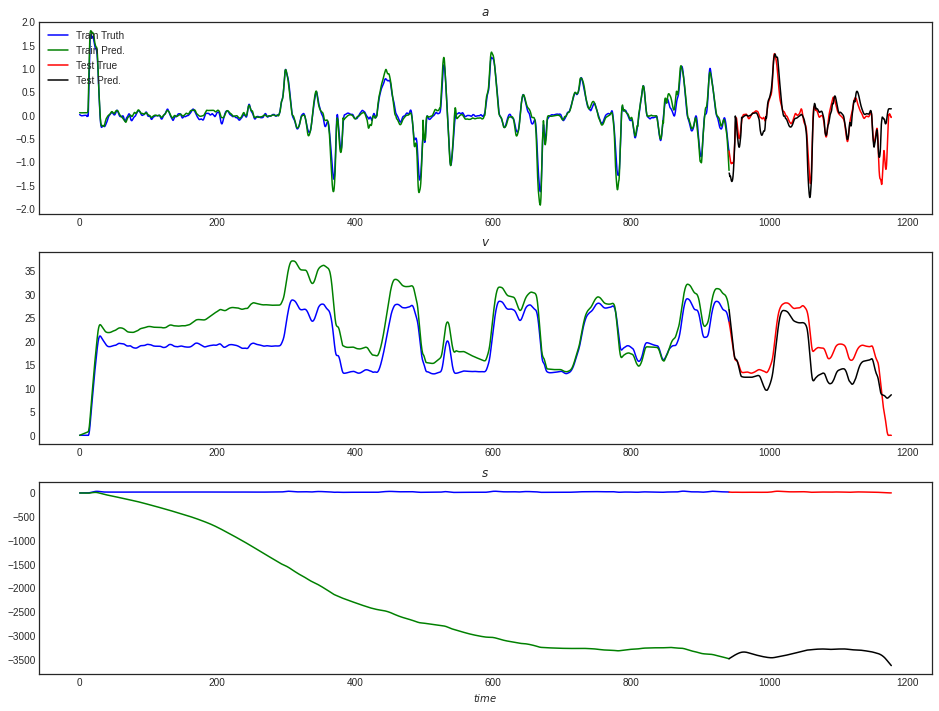

In [167]:
# Plotting 
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

#lstm_pred = np.array(df_out['Model_Forecast'])

print('Train Acc. RMSE:', np.sqrt(mean_squared_error(lstm_train_a_np, v_p[:en_Traj+1])))
print("Train Vel. RMSE", np.sqrt(mean_squared_error(lstm_train_v_np, v[:en_Traj+1])))
print("Train Head. RMSE", np.sqrt(mean_squared_error(lstm_train_s_np, s[:en_Traj+1])))

print('Test Acc. RMSE:', np.sqrt(mean_squared_error(lstm_test_a_np, v_p[en_Traj+1:])))
print("Test Vel. RMSE", np.sqrt(mean_squared_error(lstm_test_v_np, v[en_Traj+1:])))
print("Test Head. RMSE", np.sqrt(mean_squared_error(lstm_test_s_np, s[en_Traj+1:])))

fig, (ax1, ax2, ax3) = plt.subplots(3) 

fig.set_figheight(12)
fig.set_figwidth(16)

b1, = ax1.plot(X_train[:,3], Y_train[:,0], "b")
g1, = ax1.plot(X_prior[:en_Traj+1,3], lstm_train_a_np, "g")
r1, = ax1.plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax1.plot(X_prior[en_Traj+1:,3], lstm_test_a_np, "k")
ax1.set_title('$a$')

ax2.plot(X_train[:,3], X_train[:,0], "b")
ax2.plot(X_prior[:en_Traj+1,3], lstm_train_v_np, "g")
ax2.plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax2.plot(X_prior[en_Traj+1:,3], lstm_test_v_np, "k")
ax2.set_title('$v$')

ax3.plot(X_train[:,3], X_train[:,1], "b")
ax3.plot(X_prior[:en_Traj+1,3], lstm_train_s_np, "g")
ax3.plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax3.plot(X_prior[en_Traj+1:,3], lstm_test_s_np, "k")
ax3.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#43/LSTModels/ASTAZERO/LSTM_Stand_ASTA(A).png')
plt.show()

# RMSE(V)

In [59]:
train_size = np.array(df_lstm_train).shape[0]
test_size = np.array(df_lstm_test).shape[0]

lstm_train_a = torch.zeros(train_size)   # contains unnormalized predictions 
lstm_train_v = torch.zeros(train_size)
lstm_train_pos = torch.zeros(train_size)
lstm_train_s = torch.zeros(train_size)

lstm_test_a = torch.zeros(test_size)
lstm_test_v = torch.zeros(test_size)
lstm_test_pos = torch.zeros(test_size)
lstm_test_s = torch.zeros(test_size)

lstm_train_a[0] = v_p[0]
lstm_train_v[0] = v[0]
lstm_train_pos[0] = followPos[0]
lstm_train_s[0] = s[0]

#lstm_test_a[0] = v_p[train_size]
#lstm_test_v[0] = v[train_size]
#lstm_test_pos[0] = followPos[train_size]
#lstm_test_s[0] = s[train_size]

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    k = 0
    if data_loader == test_loader:
        lstm_test_a[0] = lstm_train_a[train_size-1]
        lstm_test_v[0] = lstm_train_v[train_size-1]
        lstm_test_pos[0] = lstm_train_pos[train_size-1]
        lstm_test_s[0] = lstm_train_s[train_size-1]
    with torch.no_grad():
        for X, _ in data_loader:
            if data_loader == train_eval_loader:
                if k != train_size-1:
                    y_star = model(X)                                                # Normalize VEL
                    df_lstm_train.loc[k+1, 'FOLLOW_VEL'] = y_star.item()
                    lstm_train_v[k+1] = y_star*target_stdev + target_mean            # Unnormalize VEL
                    lstm_train_a[k+1] = (lstm_train_v[k+1]-lstm_train_v[k]) / dt     # Normalize VEL   
                    lstm_train_pos[k+1] = lstm_train_pos[k] + (lstm_train_v[k])*(dt)+ (0.5)*(lstm_train_a[k])*(dt**2) # Unnormalize POS
                    lstm_train_s[k+1] = leadPos[k+1] - lstm_train_pos[k+1] - leadLen[0]           # Calculating HEADWAY
                    h_star_norm = (lstm_train_s[k+1]-headway_mean) / headway_stdev                  # Normalize HEADWAY
                    df_lstm_train.loc[k+1, 'HEADWAY'] = h_star_norm.item()             # Updating Dataframe 
            elif data_loader == test_loader:
                if k != test_size-1:
                    y_star = model(X)                                                # Normalize VEL
                    df_lstm_test.loc[k+1, 'FOLLOW_VEL'] = y_star.item()
                    lstm_test_v[k+1] = y_star*target_stdev + target_mean            # Unnormalize VEL
                    lstm_test_a[k+1] = (lstm_test_v[k+1]-lstm_test_v[k]) / dt     # Normalize VEL   
                    lstm_test_pos[k+1] = lstm_test_pos[k] + (lstm_test_v[k])*(dt)+ (0.5)*(lstm_train_a[k])*(dt**2) # Unnormalize POS
                    lstm_test_s[k+1] = leadPos[k+train_size+1] - lstm_test_pos[k+1] - leadLen[0]           # Calculating HEADWAY
                    h_star_norm = (lstm_test_s[k+1]-headway_mean) / headway_stdev                  # Normalize HEADWAY
                    df_lstm_test.loc[k+1, 'HEADWAY'] = h_star_norm.item()             # Updating Dataframe 
            k += 1     
    return output

In [60]:
train_eval_loader = DataLoader(train_eval_dataset, batch_size=1, shuffle=False) # shuffle=False

ystar_col = "Model_Forecast"
predict(train_eval_loader, model).numpy()
predict(test_loader, model).numpy()

array([], dtype=float32)

In [61]:
lstm_train_a_np = lstm_train_a.detach().cpu().numpy()
lstm_train_v_np = lstm_train_v.detach().cpu().numpy()
lstm_train_pos_np = lstm_train_pos.detach().cpu().numpy()
lstm_train_s_np = lstm_train_s.detach().cpu().numpy()

lstm_test_a_np = lstm_test_a.detach().cpu().numpy()
lstm_test_v_np = lstm_test_v.detach().cpu().numpy()
lstm_test_pos_np = lstm_test_pos.detach().cpu().numpy()
lstm_test_s_np = lstm_test_s.detach().cpu().numpy()

lstm_pred_a = np.concatenate((lstm_train_a_np, lstm_test_a_np))
lstm_pred_v = np.concatenate((lstm_train_v_np, lstm_test_v_np))
lstm_pred_pos = np.concatenate((lstm_train_pos_np, lstm_test_pos_np))
lstm_pred_s = np.concatenate((lstm_train_s_np, lstm_test_s_np))


Train Acc. RMSE: 0.28552277645293306
Train Vel. RMSE 0.20614112717517166
Train Head. RMSE 11.10480194740295
Test Acc. RMSE: 0.36021762260282203
Test Vel. RMSE 0.3912184745319936
Test Head. RMSE 20.884338477233015


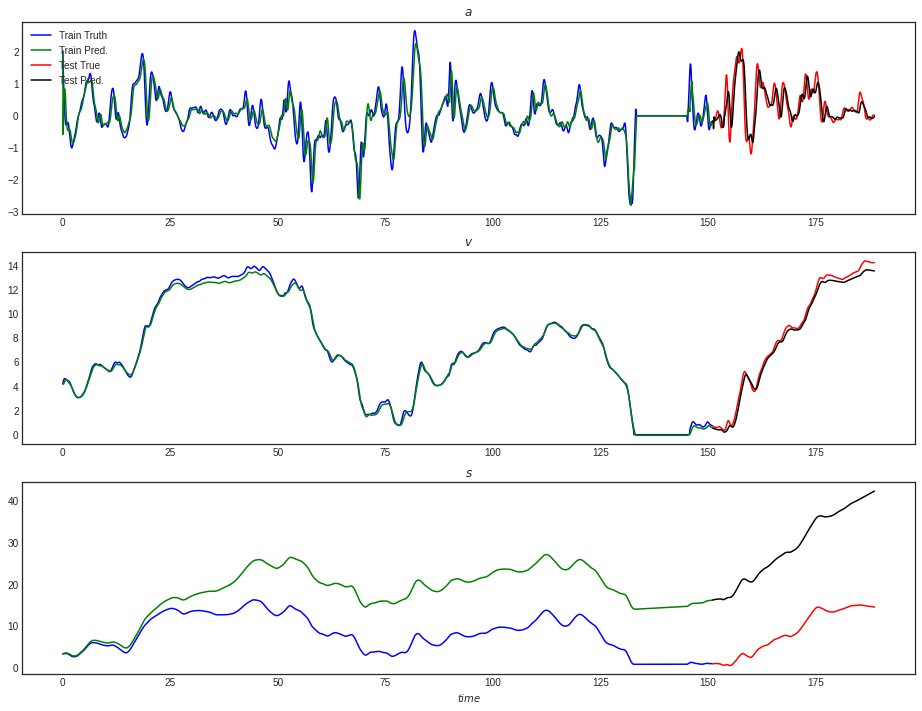

In [62]:
# Plotting 
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

#lstm_pred = np.array(df_out['Model_Forecast'])

print('Train Acc. RMSE:', np.sqrt(mean_squared_error(lstm_train_a_np, v_p[:en_Traj+1])))
print("Train Vel. RMSE", np.sqrt(mean_squared_error(lstm_train_v_np, v[:en_Traj+1])))
print("Train Head. RMSE", np.sqrt(mean_squared_error(lstm_train_s_np, s[:en_Traj+1])))

print('Test Acc. RMSE:', np.sqrt(mean_squared_error(lstm_test_a_np, v_p[en_Traj+1:])))
print("Test Vel. RMSE", np.sqrt(mean_squared_error(lstm_test_v_np, v[en_Traj+1:])))
print("Test Head. RMSE", np.sqrt(mean_squared_error(lstm_test_s_np, s[en_Traj+1:])))

fig, (ax1, ax2, ax3) = plt.subplots(3) 

fig.set_figheight(12)
fig.set_figwidth(16)

b1, = ax1.plot(X_train[:,3], v_p[:en_Traj], "b")
g1, = ax1.plot(X_prior[:en_Traj+1,3], lstm_train_a_np, "g")
r1, = ax1.plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax1.plot(X_prior[en_Traj+1:,3], lstm_test_a_np, "k")
ax1.set_title('$a$')

ax2.plot(X_train[:,3], X_train[:,0], "b")
ax2.plot(X_prior[:en_Traj+1,3], lstm_train_v_np, "g")
ax2.plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax2.plot(X_prior[en_Traj+1:,3], lstm_test_v_np, "k")
ax2.set_title('$v$')

ax3.plot(X_train[:,3], X_train[:,1], "b")
ax3.plot(X_prior[:en_Traj,3], lstm_pred_s[:en_Traj], "g")
ax3.plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax3.plot(X_prior[en_Traj:,3], lstm_pred_s[en_Traj:], "k")
ax3.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#43/LSTModels/NAPOLI/LSTM_Stand_NAPOLI(V).png')
plt.show()

# RMSE(S)

In [31]:
train_size = np.array(df_lstm_train).shape[0]
test_size = np.array(df_lstm_test).shape[0]

lstm_train_a = torch.zeros(train_size)   # contains unnormalized predictions 
lstm_train_v = torch.zeros(train_size)
lstm_train_pos = torch.zeros(train_size)
lstm_train_s = torch.zeros(train_size)

lstm_test_a = torch.zeros(test_size)
lstm_test_v = torch.zeros(test_size)
lstm_test_pos = torch.zeros(test_size)
lstm_test_s = torch.zeros(test_size)

lstm_train_a[0] = v_p[0]
lstm_train_v[0] = v[0]
lstm_train_pos[0] = followPos[0]
lstm_train_s[0] = s[0]

#lstm_test_a[0] = v_p[train_size]
#lstm_test_v[0] = v[train_size]
#lstm_test_pos[0] = followPos[train_size]
#lstm_test_s[0] = s[train_size]

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    k = 0
    if data_loader == test_loader:
        lstm_test_a[0] = lstm_train_a[train_size-1]
        lstm_test_v[0] = lstm_train_v[train_size-1]
        lstm_test_pos[0] = lstm_train_pos[train_size-1]
        lstm_test_s[0] = lstm_train_s[train_size-1]
    with torch.no_grad():
        for X, _ in data_loader:
            if data_loader == train_eval_loader:
                if k != train_size-1:
                    #if k<3:
                    #    print(df_lstm_train.iloc[k])
                    y_star = model(X)                                                    
                    df_lstm_train.loc[k+1, 'HEADWAY'] = y_star.item()                    # Updating Dataframe
                    lstm_train_s[k+1] = y_star*target_stdev + target_mean                # Unnormalize POS
                    lstm_train_pos[k+1] = leadPos[k+1] - lstm_train_s[k+1] - leadLen[0]  # Calculating HEADWAY
                    lstm_train_v[k+1] = (lstm_train_pos[k+1]-lstm_train_pos[k]) / dt     # Caclulate VEL
                    if lstm_train_v[k+1]<0:
                        lstm_train_v[k+1] = 0   
                    h_star_norm = (lstm_train_v[k+1]-vel_mean) / vel_stdev               # Normalize VEL
                    df_lstm_train.loc[k+1, 'FOLLOW_VEL'] = h_star_norm.item()            # Updating Dataframe 
                    lstm_train_a[k+1] = (lstm_train_v[k+1]-lstm_train_v[k]) / dt         # Caclulate ACC
                    if lstm_train_a[k+1] < min_acc:
                        lstm_train_a[k+1] = min_acc
                    elif lstm_train_a[k+1] > max_acc:
                        lstm_train_a[k+1] = max_acc                        
                    #if k<3:
                    #    print(df_lstm_train.iloc[k+1])
            elif data_loader == test_loader:
                if k != test_size-1:
                    y_star = model(X)                                                    
                    df_lstm_test.loc[k+1, 'HEADWAY'] = y_star.item()                    # Updating Dataframe
                    lstm_test_s[k+1] = y_star*target_stdev + target_mean                # Unnormalize HDWY
                    lstm_test_pos[k+1] = leadPos[k+train_size] - lstm_test_s[k+1] - leadLen[0]  # Calculating POS
                    lstm_test_v[k+1] = (lstm_test_pos[k+1]-lstm_test_pos[k]) / dt     # Caclulate VEL
                    if lstm_train_v[k+1]<0:
                           lstm_train_v[k+1] = 0
                    h_star_norm = (lstm_test_v[k+1]-vel_mean) / vel_stdev               # Normalize VEL
                    df_lstm_test.loc[k+1, 'FOLLOW_VEL'] = h_star_norm.item()            # Updating Dataframe 
                    lstm_test_a[k+1] = (lstm_test_v[k+1]-lstm_test_v[k]) / dt         # Caclulate ACC
                    if lstm_test_a[k+1] < min_acc:
                        lstm_test_a[k+1] = min_acc
                    elif lstm_test_a[k+1] > max_acc:
                        lstm_test_a[k+1] = max_acc
            k += 1     
    return output

In [32]:
train_eval_loader = DataLoader(train_eval_dataset, batch_size=1, shuffle=False) # shuffle=False

ystar_col = "Model_Forecast"
predict(train_eval_loader, model).numpy()
predict(test_loader, model).numpy()

array([], dtype=float32)

In [33]:
lstm_train_a_np = lstm_train_a.detach().cpu().numpy()
lstm_train_v_np = lstm_train_v.detach().cpu().numpy()
lstm_train_pos_np = lstm_train_pos.detach().cpu().numpy()
lstm_train_s_np = lstm_train_s.detach().cpu().numpy()

lstm_test_a_np = lstm_test_a.detach().cpu().numpy()
lstm_test_v_np = lstm_test_v.detach().cpu().numpy()
lstm_test_pos_np = lstm_test_pos.detach().cpu().numpy()
lstm_test_s_np = lstm_test_s.detach().cpu().numpy()

lstm_pred_a = np.concatenate((lstm_train_a_np, lstm_test_a_np))
lstm_pred_v = np.concatenate((lstm_train_v_np, lstm_test_v_np))
lstm_pred_pos = np.concatenate((lstm_train_pos_np, lstm_test_pos_np))
lstm_pred_s = np.concatenate((lstm_train_s_np, lstm_test_s_np))


Train Acc. RMSE: 0.27651816663069867
Train Vel. RMSE 0.07836113604134391
Train Head. RMSE 0.09309954457195607
Test Acc. RMSE: 0.40952592573678204
Test Vel. RMSE 0.15993849691175968
Test Head. RMSE 0.12419473624047388


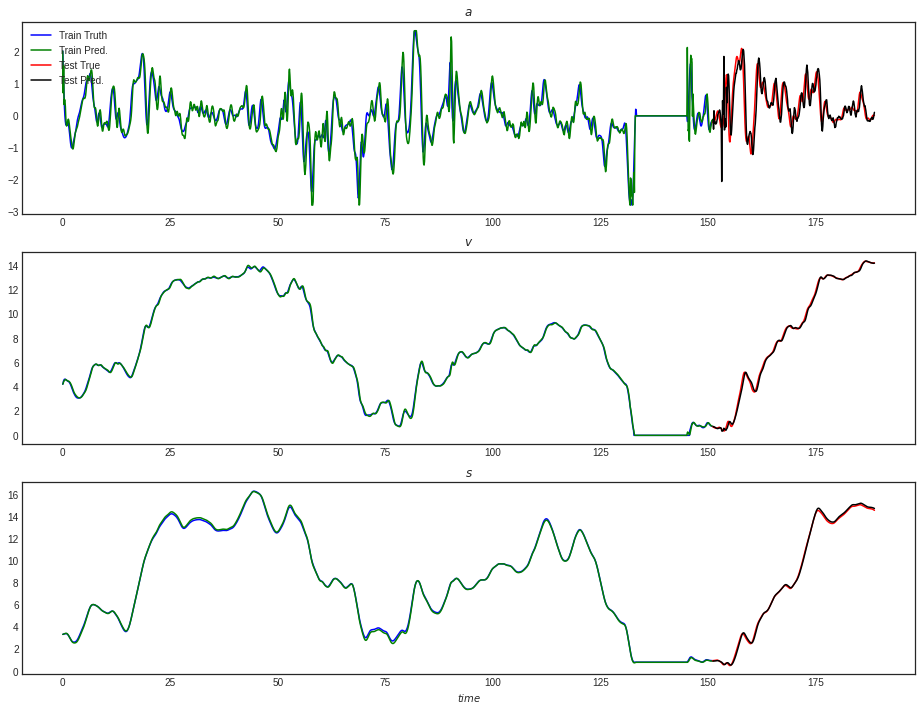

In [34]:
# Plotting 
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

#lstm_pred = np.array(df_out['Model_Forecast'])

print('Train Acc. RMSE:', np.sqrt(mean_squared_error(lstm_train_a_np, v_p[:en_Traj+1])))
print("Train Vel. RMSE", np.sqrt(mean_squared_error(lstm_train_v_np, v[:en_Traj+1])))
print("Train Head. RMSE", np.sqrt(mean_squared_error(lstm_train_s_np, s[:en_Traj+1])))

print('Test Acc. RMSE:', np.sqrt(mean_squared_error(lstm_test_a_np, v_p[en_Traj+1:])))
print("Test Vel. RMSE", np.sqrt(mean_squared_error(lstm_test_v_np, v[en_Traj+1:])))
print("Test Head. RMSE", np.sqrt(mean_squared_error(lstm_test_s_np, s[en_Traj+1:])))

fig, (ax1, ax2, ax3) = plt.subplots(3) 

fig.set_figheight(12)
fig.set_figwidth(16)

b1, = ax1.plot(X_train[:,3], v_p[:en_Traj], "b")
g1, = ax1.plot(X_prior[:en_Traj+1,3], lstm_train_a_np, "g")
r1, = ax1.plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax1.plot(X_prior[en_Traj+1:,3], lstm_test_a_np, "k")
ax1.set_title('$a$')

ax2.plot(X_train[:,3], X_train[:,0], "b")
ax2.plot(X_prior[:en_Traj+1,3], lstm_train_v_np, "g")
ax2.plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax2.plot(X_prior[en_Traj+1:,3], lstm_test_v_np, "k")
ax2.set_title('$v$')

ax3.plot(X_train[:,3], X_train[:,1], "b")
ax3.plot(X_prior[:en_Traj+1,3], lstm_train_s_np, "g")
ax3.plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax3.plot(X_prior[en_Traj+1:,3], lstm_test_s_np, "k")
ax3.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#43/LSTModels/NAPOLI/LSTM_Stand_NAPOLI(S).png')
plt.show()

In [129]:
print(lstm_train_a[2304:2308], lstm_test_a[0:5])
print(lstm_train_v[2304:2308], lstm_test_v[0:5])
print(lstm_train_pos[2304:2308], lstm_test_pos[0:5])

tensor([-0.0977, -0.2441, -0.3174, -0.3906]) tensor([ -0.3906,  16.1621, -24.5605,   2.0508,   1.4648])
tensor([10.9741, 10.9497, 10.9180, 10.8789]) tensor([10.8789, 12.4951, 10.0391, 10.2441, 10.3906])
tensor([2313.4255, 2314.5205, 2315.6123, 2316.7002]) tensor([2316.7002, 2317.9497, 2318.9536, 2319.9780, 2321.0171])


In [91]:
lstm_train_v[train_size-1]

tensor(10.8789)

In [76]:
s[2307]

10.137850000000071

In [31]:
followPos[:10]

array([188.0478, 188.0478, 188.0478, 188.0478, 188.0478, 188.0478,
       188.0478, 188.0478, 188.0478, 188.0478])

In [39]:
lstm_train_pos[3]-lstm_train_pos[2]

tensor(0.2672)

In [35]:
lstm_train_v[:10]

tensor([0.0000, 0.0000, 3.6174, 2.6715, 1.7155, 0.7780, 0.0000, 0.0000, 0.0000,
        0.0000])

In [37]:
v[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [96]:
lstm_test_a[1]

tensor(16.1621)